In [1]:

# Example notebook to parse and plot Summit CPC data.
# By Heather Guy, 2019-11-20

# Import useful packages.

import matplotlib
#matplotlib.use('Agg')
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as md
import pandas as pd
from matplotlib import rcParams
import matplotlib.colors as colors
import os
import glob
from scipy import io

import sys
sys.path.append('/Users/heather/ICECAPS-ACE/DataParse/')

from ace_parse import *
from utils import * 


In [2]:
# Function to parse CPC data

def get_opc(start,stop,d_loc):
    f_date_list = pd.date_range(start.date(),stop.date(),freq='1D')
    out = pd.DataFrame(columns=list(np.arange(0,24,1))+['QC'])
    for date in f_date_list:
        f = d_loc + r'MSF_OPC_%s'%(str(date.date()))
        
        try:
            data = pd.read_csv(f,parse_dates=[0],index_col=[0],skiprows=1,names=list(np.arange(0,24,1))+['QC'])
        except:
            print('No data for %s'%str(date.date()))
            continue

        out = out.append(data,sort=True)    
    
    # Get rid of any duplicates
    out = out[~out.index.duplicated()]
    
    # Fill any missing minutes with nans
    new_index = pd.date_range(out.index[0],out.index[-1] , freq='min')
    out = out.reindex(new_index)
    
    # Crop to datetime
    out=out[start:stop]
    
    return out
    
def get_skyopc(start,stop,d_loc):
    f_date_list = pd.date_range(start.date(),stop.date(),freq='1D')
    SKY_out = pd.DataFrame(columns=list(np.arange(0,31,1))+['QC'])
    for date in f_date_list:
        f = d_loc + r'SKYOPC_%s'%(str(date.date()))
        
        try:
            data = pd.read_csv(f,parse_dates=[0],index_col=[0],skiprows=1,names=list(np.arange(0,31,1))+['QC'])
        except:
            print('No data for %s'%str(date.date()))
            continue

        SKY_out = SKY_out.append(data,sort=True)    
    
    # Get rid of any duplicates
    SKY_out = SKY_out[~SKY_out.index.duplicated()]
    
    # Fill any missing minutes with nans
    new_index = pd.date_range(SKY_out.index[0],SKY_out.index[-1] , freq='min')
    SKY_out = SKY_out.reindex(new_index)
    
    # Crop to datetime
    SKY_out=SKY_out[start:stop]
    
    return SKY_out

In [3]:
# Get the data

d_loc = '/Volumes/Data/ICECAPSarchive/ace/processed/MSF_OPC/'
d1 = dt.datetime(2019,8,1,0,0)
d2 = dt.datetime(2019,12,28,23,59)

opc = get_opc(d1,d2,d_loc)
opc_qc = opc.copy()[opc.keys()[:-1]]
opc_qc[opc['QC']!=1]=np.nan

No data for 2019-10-22
No data for 2019-10-23


In [4]:
d_loc = '/Volumes/Data/ICECAPSarchive/ace/processed/SKYOPC/'
skyopc = get_skyopc(d1,d2,d_loc)
skyopc_qc = skyopc.copy()[skyopc.keys()[:-1]]
skyopc_qc[skyopc['QC']!=1]=np.nan

No data for 2019-08-15
No data for 2019-08-17


In [5]:
opc_size_hist = opc_qc.sum()
opc_tot_counts = opc_qc.sum(axis=1)
opc_tot_counts_no_qc = opc[opc.keys()[:-1]].sum(axis=1)
opc_tot_counts[opc_tot_counts==0]=np.nan
opc_tot_counts_no_qc[opc_tot_counts_no_qc==0]=np.nan

In [6]:
sky_size_hist = skyopc_qc.sum()
sky_tot_counts = skyopc_qc.sum(axis=1)
sky_tot_counts_no_qc = skyopc[skyopc.keys()[:-1]].sum(axis=1)

sky_tot_counts[sky_tot_counts==0]=np.nan
sky_tot_counts_no_qc[sky_tot_counts_no_qc==0]=np.nan

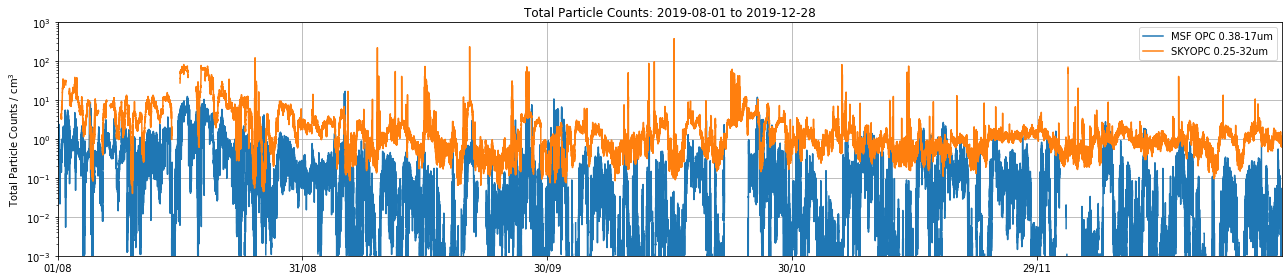

In [7]:
# Plot total counts No QC

fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(111)
ax.grid(True)
ax.semilogy(opc_tot_counts_no_qc.index,opc_tot_counts_no_qc, label='MSF OPC 0.38-17um') 
ax.semilogy(sky_tot_counts_no_qc.index,sky_tot_counts_no_qc, label='SKYOPC 0.25-32um')   
ax.set_ylim(0.001,1000)
ax.set_ylabel('Total Particle Counts / cm$^3$')
ax.set_title('Total Particle Counts: %s'%((dt.datetime.strftime(d1,'%Y-%m-%d')+' to '+dt.datetime.strftime(d2,'%Y-%m-%d'))))
ax.xaxis.set_major_formatter(md.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(md.DayLocator(interval=30))
ax.set_xlim(d1,d2)
ax.legend(loc='best',fontsize=10)
fig.tight_layout()
#fig.savefig(d_loc + 'Ncounts_current.png')


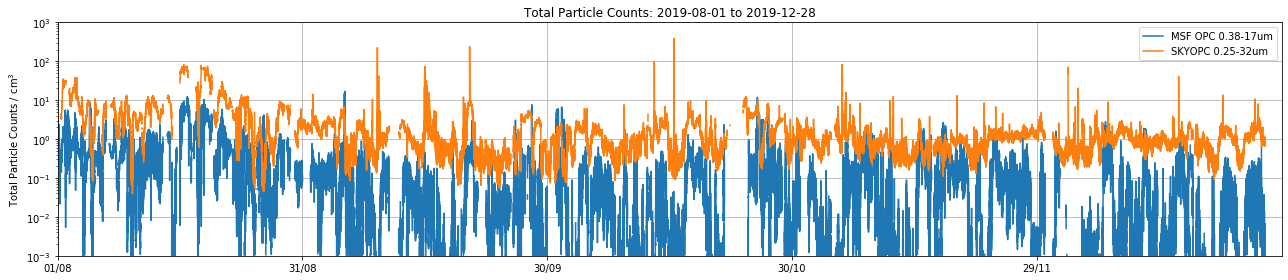

In [8]:
# Plot total counts with QC

fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(111)
ax.grid(True)
ax.semilogy(opc_tot_counts.index,opc_tot_counts, label='MSF OPC 0.38-17um')  
ax.semilogy(sky_tot_counts.index,sky_tot_counts, label='SKYOPC 0.25-32um') 
ax.set_ylim(0.001,1000)
ax.set_ylabel('Total Particle Counts / cm$^3$')
ax.set_title('Total Particle Counts: %s'%((dt.datetime.strftime(d1,'%Y-%m-%d')+' to '+dt.datetime.strftime(d2,'%Y-%m-%d'))))
ax.xaxis.set_major_formatter(md.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(md.DayLocator(interval=30))
ax.set_xlim(d1,d2)
ax.legend(loc='best',fontsize=10)
fig.tight_layout()
#fig.savefig(d_loc + 'Ncounts_current.png')

In [9]:
# Aerosol counts frequency plot (histogram)

nbins = 1000
bins = np.logspace(0.001,4,nbins)
#widths = np.linspace(1,4,nbins-1)
opc_hist_tot = np.histogram(opc_tot_counts, bins=bins)[0]
sky_hist_tot = np.histogram(sky_tot_counts, bins=bins)[0]



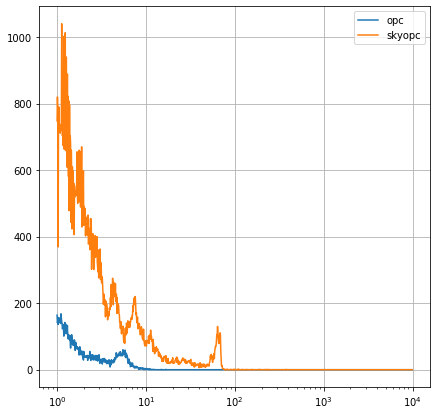

In [11]:
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111)
ax1.grid(True)


#ax1.bar(bins[:-1],hist,width=widths,align='edge')
ax1.plot(bins[:-1],opc_hist_tot,label='opc')
ax1.plot(bins[:-1],sky_hist_tot,label='skyopc')

ax1.set_xscale('log')
#ax1.set_yscale('log')

#ax.set_ylabel('Total Particle Counts / cm$^3$')
#ax.set_title('Total Particle Counts: %s'%((dt.datetime.strftime(d1,'%Y-%m-%d')+' to '+dt.datetime.strftime(d2,'%Y-%m-%d'))))
#ax.xaxis.set_major_formatter(md.DateFormatter('%d/%m'))
#ax.xaxis.set_major_locator(md.DayLocator(interval=30))
#ax.set_xlim(d1,d2)
ax1.legend(loc='best',fontsize=10)
#plt.bar(bins[:-1],hist,align='edge')

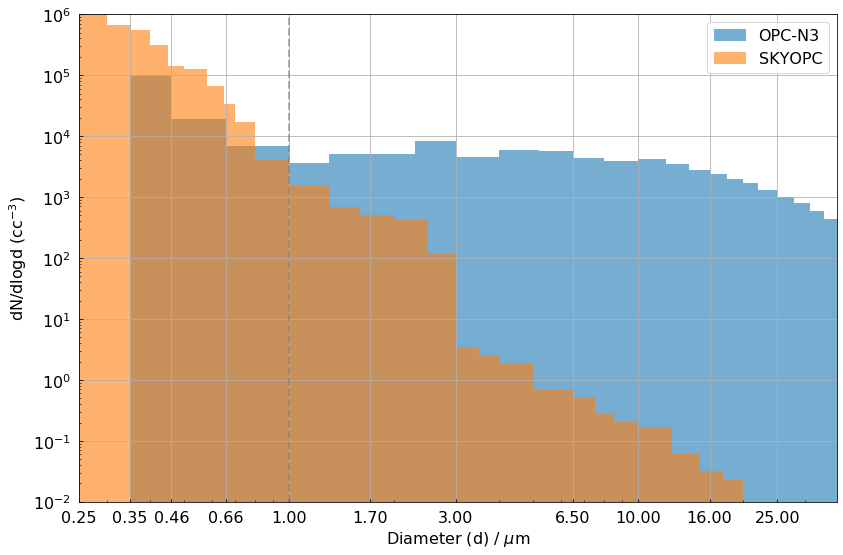

In [26]:

from matplotlib import rcParams
# Plotting preferences:
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 16}) 
rcParams['axes.titlepad'] = 16 
rcParams['xtick.major.pad']='8'
rcParams['ytick.major.pad']='8'


# Plot size distribution histogram
opc_bins = 24
opc_bounds = [0.35, 0.46, 0.66, 1, 1.3, 1.7, 2.3, 3, 4, 5.2, 6.5, 8, 10, 12, 14, 16, 18, 20, 22, 25, 28, 31, 34, 37, 40]

sky_bins = 31
sky_bounds = [0.25,0.28,0.3,0.35,0.4,0.45,0.5,0.58,0.65,0.7,0.8,1.0,1.3,1.6,2,2.5,3,3.5,4,5,6.5,7.5,8.5,10,12.5,15,17.5,20,25,30,32,40]


opc_mid_points,opc_dNdlogd = get_dist(opc_qc,opc_bins,opc_bounds)
opc_bar_widths=[]
for i in range(0,len(opc_mid_points)):
    opc_bar_widths.append(opc_bounds[i+1]-opc_bounds[i])

sky_mid_points,sky_dNdlogd = get_dist(skyopc_qc,sky_bins,sky_bounds)
sky_bar_widths=[]
for i in range(0,len(sky_mid_points)):
    sky_bar_widths.append(sky_bounds[i+1]-sky_bounds[i])
    
    
    

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.grid(True)
ax.bar(opc_mid_points,opc_dNdlogd,width=opc_bar_widths,alpha=0.6,label='OPC-N3')
ax.bar(sky_mid_points,sky_dNdlogd,width=sky_bar_widths,alpha=0.6, label='SKYOPC')

ax.set_xlim(sky_bounds[0],opc_bounds[-2])
ax.set_ylim(0.01, 1000000)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xticks([0.25,0.35, 0.46, 0.66, 1, 1.7, 3,6.5,10, 16, 25])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.axvline(1, c='grey',ls='--',lw=2,alpha=0.6)

ax.legend()

ax.set_xlabel('Diameter (d) / $\mu$m')
ax.set_ylabel('dN/dlogd (cc$^{-3}$)')
#ax.set_title('Aerosol size distribution: %s'%((dt.datetime.strftime(d1,'%Y-%m-%d')+' to '+dt.datetime.strftime(d2,'%Y-%m-%d'))))
fig.tight_layout()
#fig.savefig(d_loc + 'Spectra_current.png')
#    fig.clf()

In [21]:
opc_bar_widths

[0.11000000000000004,
 0.2,
 0.33999999999999997,
 0.30000000000000004,
 0.3999999999999999,
 0.5999999999999999,
 0.7000000000000002,
 1,
 1.2000000000000002,
 1.2999999999999998,
 1.5,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3]

In [22]:
sky_bar_widths

[0.030000000000000027,
 0.019999999999999962,
 0.04999999999999999,
 0.050000000000000044,
 0.04999999999999999,
 0.04999999999999999,
 0.07999999999999996,
 0.07000000000000006,
 0.04999999999999993,
 0.10000000000000009,
 0.19999999999999996,
 0.30000000000000004,
 0.30000000000000004,
 0.3999999999999999,
 0.5,
 0.5,
 0.5,
 0.5,
 1,
 1.5,
 1.0,
 1.0,
 1.5,
 2.5,
 2.5,
 2.5,
 2.5,
 5,
 5,
 2,
 8]

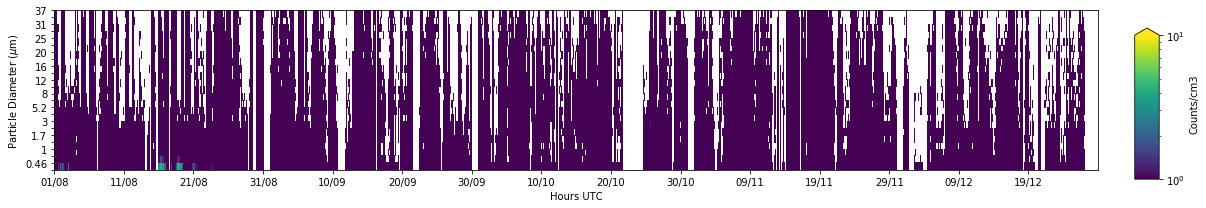

In [63]:
# Plot size distribution time series

# Plot time series spectra
opc_ts = opc_qc.to_numpy()
opc_dates = np.array(opc_qc.index.to_pydatetime())

fig, axs = plt.subplots(nrows=1, ncols=1,squeeze=0,sharex=True,figsize=(17,3))
cs = axs[0][0].pcolormesh(opc_dates,np.arange(0,opc_bins,1),np.transpose(opc_ts),norm=colors.LogNorm(vmin=1, vmax=10),cmap='viridis')
axs[0][0].xaxis_date()
#axs[0][0].set_title('%s, %s to %s'%(name,dt.datetime.strftime(d1,'%Y-%m-%d'),dt.datetime.strftime(d2,'%Y-%m-%d')))

axs[0][0].set_yticks(np.arange(0,len(opc_bounds)-1,1))
axs[0][0].tick_params(axis='y', which='major', labelsize=10) 
for label in axs[0][0].yaxis.get_ticklabels()[::2]:
    label.set_visible(False)
axs[0][0].set_yticklabels(opc_bounds)
 




axs[0][0].set_ylabel('Particle Diameter ($\mu$m)')
axs[0][0].set_xlabel('Hours UTC')
axs[0][0].set_xlim(d1,d2)



myFmt = md.DateFormatter('%d/%m')
rule = md.DayLocator(interval=10)
axs[0][0].xaxis.set_major_formatter(myFmt)
axs[0][0].xaxis.set_major_locator(rule)   

fig.tight_layout()    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(cs,cax=cbar_ax,extend='max',label='Counts/cm3')

In [64]:
bins

array([1.00230524e+00, 1.01158645e+00, 1.02095360e+00, 1.03040750e+00,
       1.03994893e+00, 1.04957872e+00, 1.05929767e+00, 1.06910663e+00,
       1.07900641e+00, 1.08899786e+00, 1.09908183e+00, 1.10925918e+00,
       1.11953077e+00, 1.12989748e+00, 1.14036018e+00, 1.15091976e+00,
       1.16157712e+00, 1.17233316e+00, 1.18318881e+00, 1.19414498e+00,
       1.20520260e+00, 1.21636261e+00, 1.22762597e+00, 1.23899362e+00,
       1.25046653e+00, 1.26204568e+00, 1.27373205e+00, 1.28552664e+00,
       1.29743044e+00, 1.30944447e+00, 1.32156975e+00, 1.33380731e+00,
       1.34615818e+00, 1.35862343e+00, 1.37120410e+00, 1.38390126e+00,
       1.39671600e+00, 1.40964940e+00, 1.42270256e+00, 1.43587660e+00,
       1.44917262e+00, 1.46259176e+00, 1.47613516e+00, 1.48980398e+00,
       1.50359936e+00, 1.51752249e+00, 1.53157454e+00, 1.54575671e+00,
       1.56007021e+00, 1.57451625e+00, 1.58909606e+00, 1.60381087e+00,
       1.61866194e+00, 1.63365053e+00, 1.64877792e+00, 1.66404538e+00,
      